Loading wine dataset...
Dataset shape: (178, 13)
Number of features: 13
Number of samples: 178

Running k-means algorithm 30 times...

Number of unique partitions found: 21

Partition frequencies:
Partition 1: 2 times
Partition 2: 2 times
Partition 3: 2 times
Partition 4: 2 times
Partition 5: 2 times
Partition 6: 2 times
Partition 7: 2 times
Partition 8: 2 times
Partition 9: 2 times
Partition 10: 1 times
Partition 11: 1 times
Partition 12: 1 times
Partition 13: 1 times
Partition 14: 1 times
Partition 15: 1 times
Partition 16: 1 times
Partition 17: 1 times
Partition 18: 1 times
Partition 19: 1 times
Partition 20: 1 times
Partition 21: 1 times

W(P) and B(P) values for each partition type:
Partition 1 (appeared 1 times):
  Average W(P): 1278.7608
  Average B(P): 1035.2392
Partition 2 (appeared 1 times):
  Average W(P): 1279.7311
  Average B(P): 1034.2689
Partition 3 (appeared 1 times):
  Average W(P): 1279.7311
  Average B(P): 1034.2689
Partition 4 (appeared 2 times):
  Average W(P): 127

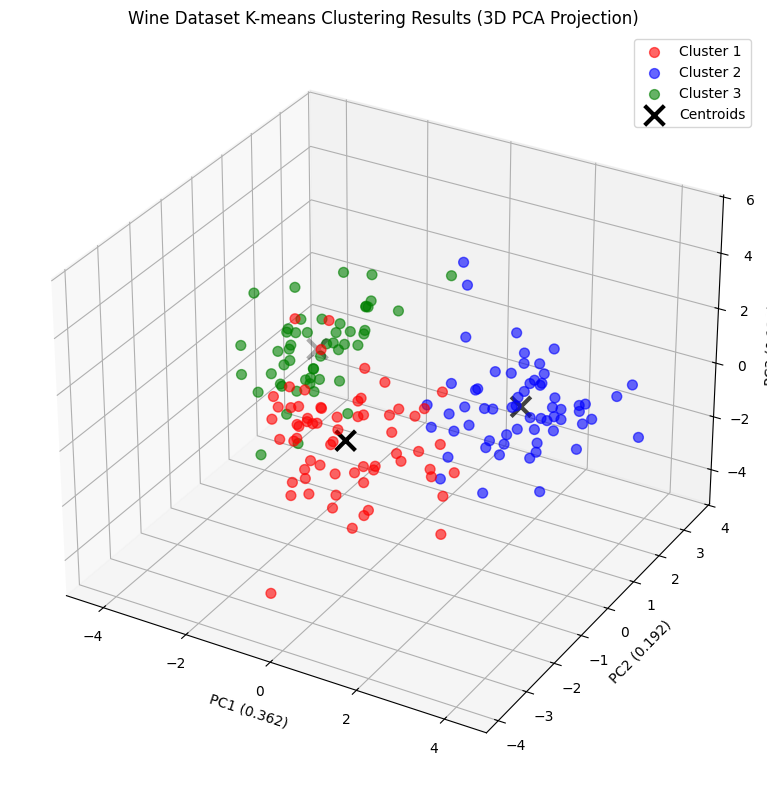


Summary Table:
Metric                    Value
Dataset samples           178
Dataset features          13
Number of runs            30
Unique partitions         21
Best W(P)                 1277.9285
Best B(P)                 1036.0715
Total explained var.      0.6653

Clustering Quality Metrics:
Adjusted Rand Index: 0.8975
Normalized Mutual Information: 0.8759

Cluster sizes in best partition:
Cluster 1: 65 samples
Cluster 2: 62 samples
Cluster 3: 51 samples


In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
K-means Algorithm Implementation and Wine Dataset Analysis
"""

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import load_wine
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

class KMeans:
    """
    Implementation of K-means algorithm based on Forgy's method
    """

    def __init__(self, k=3, max_iters=100, random_state=None):
        self.k = k
        self.max_iters = max_iters
        self.random_state = random_state

    def _initialize_centroids(self, X):
        """Initialize centroids randomly"""
        if self.random_state:
            np.random.seed(self.random_state)

        n_samples, n_features = X.shape
        centroids = np.zeros((self.k, n_features))

        for i in range(self.k):
            centroids[i] = X[np.random.choice(n_samples)]

        return centroids

    def _assign_clusters(self, X, centroids):
        """Assign each point to the nearest centroid"""
        distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
        return np.argmin(distances, axis=0)

    def _update_centroids(self, X, labels):
        """Update centroids based on current cluster assignments"""
        centroids = np.zeros((self.k, X.shape[1]))
        for i in range(self.k):
            if np.sum(labels == i) > 0:
                centroids[i] = X[labels == i].mean(axis=0)
            else:
                # If cluster is empty, reinitialize randomly
                centroids[i] = X[np.random.choice(X.shape[0])]
        return centroids

    def _calculate_wcss(self, X, labels, centroids):
        """Calculate Within-Cluster Sum of Squares (W(P))"""
        wcss = 0
        for i in range(self.k):
            cluster_points = X[labels == i]
            if len(cluster_points) > 0:
                wcss += np.sum((cluster_points - centroids[i])**2)
        return wcss

    def _calculate_bcss(self, X, labels, centroids):
        """Calculate Between-Cluster Sum of Squares (B(P))"""
        overall_mean = np.mean(X, axis=0)
        bcss = 0
        for i in range(self.k):
            n_i = np.sum(labels == i)
            if n_i > 0:
                bcss += n_i * np.sum((centroids[i] - overall_mean)**2)
        return bcss

    def fit(self, X):
        """Fit the k-means algorithm to the data"""
        # Initialize centroids
        self.centroids = self._initialize_centroids(X)

        for _ in range(self.max_iters):
            # Assign points to clusters
            labels = self._assign_clusters(X, self.centroids)

            # Update centroids
            new_centroids = self._update_centroids(X, labels)

            # Check for convergence
            if np.allclose(self.centroids, new_centroids):
                break

            self.centroids = new_centroids

        self.labels_ = labels
        self.wcss_ = self._calculate_wcss(X, labels, self.centroids)
        self.bcss_ = self._calculate_bcss(X, labels, self.centroids)

        return self

    def predict(self, X):
        """Predict cluster labels for new data"""
        return self._assign_clusters(X, self.centroids)

def partition_to_string(labels):
    """Convert partition labels to a string for comparison"""
    # Sort the labels to normalize the partition representation
    unique_labels = np.unique(labels)
    label_map = {old_label: new_label for new_label, old_label in enumerate(unique_labels)}
    normalized_labels = np.array([label_map[label] for label in labels])
    return ''.join(map(str, normalized_labels))

# Load wine dataset
print("Loading wine dataset...")
X, y = load_wine(return_X_y=True)
print(f"Dataset shape: {X.shape}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of samples: {X.shape[0]}")

# Standardize the data (important for k-means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Run k-means 30 times
print("\nRunning k-means algorithm 30 times...")
results = []
partitions = []

for i in range(30):
    kmeans = KMeans(k=3, max_iters=100, random_state=i)
    kmeans.fit(X_scaled)

    results.append({
        'run': i+1,
        'labels': kmeans.labels_.copy(),
        'centroids': kmeans.centroids.copy(),
        'wcss': kmeans.wcss_,
        'bcss': kmeans.bcss_,
        'partition_str': partition_to_string(kmeans.labels_)
    })

    partitions.append(partition_to_string(kmeans.labels_))

# Count partition frequencies
partition_counts = Counter(partitions)
print(f"\nNumber of unique partitions found: {len(partition_counts)}")
print("\nPartition frequencies:")
for i, (partition, count) in enumerate(partition_counts.most_common()):
    print(f"Partition {i+1}: {count} times")

# Report W(P) and B(P) for each unique partition
print("\nW(P) and B(P) values for each partition type:")
partition_stats = {}
for result in results:
    partition_str = result['partition_str']
    if partition_str not in partition_stats:
        partition_stats[partition_str] = {
            'wcss_values': [],
            'bcss_values': [],
            'count': 0
        }
    partition_stats[partition_str]['wcss_values'].append(result['wcss'])
    partition_stats[partition_str]['bcss_values'].append(result['bcss'])
    partition_stats[partition_str]['count'] += 1

for i, (partition_str, stats) in enumerate(partition_stats.items()):
    avg_wcss = np.mean(stats['wcss_values'])
    avg_bcss = np.mean(stats['bcss_values'])
    print(f"Partition {i+1} (appeared {stats['count']} times):")
    print(f"  Average W(P): {avg_wcss:.4f}")
    print(f"  Average B(P): {avg_bcss:.4f}")

# Find the result with minimum W(P)
best_result = min(results, key=lambda x: x['wcss'])
print(f"\nBest partition (minimum W(P)):")
print(f"Run number: {best_result['run']}")
print(f"W(P): {best_result['wcss']:.4f}")
print(f"B(P): {best_result['bcss']:.4f}")

# Use PCA for 3D visualization
print("\nApplying PCA for 3D visualization...")
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Transform centroids to PCA space
centroids_pca = pca.transform(best_result['centroids'])

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {pca.explained_variance_ratio_.sum():.4f}")

# Create 3D visualization
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Define colors for clusters
colors = ['red', 'blue', 'green']
cluster_names = ['Cluster 1', 'Cluster 2', 'Cluster 3']

# Plot data points
for i in range(3):
    mask = best_result['labels'] == i
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], X_pca[mask, 2],
              c=colors[i], label=cluster_names[i], alpha=0.6, s=50)

# Plot centroids as black points
ax.scatter(centroids_pca[:, 0], centroids_pca[:, 1], centroids_pca[:, 2],
          c='black', s=200, marker='x', linewidths=3, label='Centroids')

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f})')
ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.3f})')
ax.set_title('Wine Dataset K-means Clustering Results (3D PCA Projection)')
ax.legend()

plt.tight_layout()
plt.show()

# Create a summary table
print("\nSummary Table:")
print("=" * 60)
print(f"{'Metric':<25} {'Value'}")
print("=" * 60)
print(f"{'Dataset samples':<25} {X.shape[0]}")
print(f"{'Dataset features':<25} {X.shape[1]}")
print(f"{'Number of runs':<25} 30")
print(f"{'Unique partitions':<25} {len(partition_counts)}")
print(f"{'Best W(P)':<25} {best_result['wcss']:.4f}")
print(f"{'Best B(P)':<25} {best_result['bcss']:.4f}")
print(f"{'Total explained var.':<25} {pca.explained_variance_ratio_.sum():.4f}")
print("=" * 60)

# Additional analysis: Compare with true labels
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Calculate clustering quality metrics
ari = adjusted_rand_score(y, best_result['labels'])
nmi = normalized_mutual_info_score(y, best_result['labels'])

print(f"\nClustering Quality Metrics:")
print(f"Adjusted Rand Index: {ari:.4f}")
print(f"Normalized Mutual Information: {nmi:.4f}")

# Show cluster sizes
unique, counts = np.unique(best_result['labels'], return_counts=True)
print(f"\nCluster sizes in best partition:")
for cluster, count in zip(unique, counts):
    print(f"Cluster {cluster + 1}: {count} samples")